In [1]:
%load_ext jupyter_black
%matplotlib inline

In [2]:
import numpyro

numpyro.set_platform("gpu")

In [3]:
from typing import Dict, List, Optional
from jaxtyping import Array, PRNGKeyArray
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import equinox as eqx

import jax.random as jr
import jax.numpy as jnp
import jax.tree_util as jtu

from jax import nn, lax, vmap

from pymdp.jax.agent import Agent as AIFAgent

from pybefit.inference import (
    run_nuts,
    run_svi,
    default_dict_nuts,
    default_dict_numpyro_svi,
)

from pybefit.inference import NumpyroModel, NumpyroGuide
from pybefit.inference import Normal, NormalPosterior
from pybefit.inference.numpyro.likelihoods import pymdp_likelihood as likelihood

from numpyro.infer.autoguide import AutoNormal, AutoMultivariateNormal
from numpyro.infer import Predictive

from pymdp.jax.task import PyMDPEnv
from pymdp.utils import random_A_matrix, random_B_matrix
from equinox import Module, field

seed_key = jr.PRNGKey(101)

In [4]:
""" Defining state factors """
agency_names = [
    "selfPositive_otherPositive",
    "selfPositive_otherNegative",
    "selfNegative_otherPositive",
    "selfNegative_otherNegative",
]
self_action_names = ["self_buttonpress", "self_buttonnotpress"]
other_action_names = ["other_buttonpress", "other_buttonnotpress"]

""" Defining number of state factors and states """
num_states = [len(agency_names), len(self_action_names), len(other_action_names)]
num_factors = len(num_states)

""" Defining control state factors """
choice_agency_names = ["no_changes"]
choice_self_action_names = ["self_pressbutton", "self_notpressbutton"]
choice_other_action_names = ["equal_distribution"]

""" Defining number of control states """
num_controls = [
    len(choice_agency_names),
    len(choice_self_action_names),
    len(choice_other_action_names),
]

""" Defining observational modalities """
obs_outcome_names = ["outcome_present", "outcome_absent"]
obs_choice_self_names = ["self_buttonpress", "self_buttonnotpress"]
obs_choice_other_names = ["other_buttonpress", "other_buttonnotpress"]

""" Defining number of observational modalities and observations """
num_obs = [
    len(obs_outcome_names),
    len(obs_choice_self_names),
    len(obs_choice_other_names),
]
num_modalities = len(num_obs)

batch_size = 80  # number of subjects
num_blocks = 15
num_timesteps = 25

In [5]:
num_exp_conditions = 5


def make_agency_task(p_outcome_env=1.0, p_other_action_env=0.5):
    a1 = jnp.array([p_outcome_env, 1 - p_outcome_env])
    a2 = 1 - a1
    a3 = jnp.array([0.5, 0.5])
    A1 = jnp.stack([a1, a2, a1, a2, a3], -1)
    A2 = jnp.stack([a1, a2, a2, a1, a3], -1)
    A3 = jnp.stack([a2, a1, a1, a2, a3], -1)
    A4 = jnp.stack([a2, a1, a2, a1, a3], -1)
    _A = jnp.stack([A1, A2, A3, A4], -1).reshape(2, 5, 2, 2)

    a = jnp.eye(2)
    A = [
        jnp.broadcast_to(_A, (batch_size,) + _A.shape),
        jnp.broadcast_to(a, (batch_size,) + a.shape),
        jnp.broadcast_to(a, (batch_size,) + a.shape),
    ]

    B2 = jnp.stack([jnp.array([[1, 1], [0, 0]]), jnp.array([[0, 0], [1, 1]])], -1)
    B = [
        jnp.broadcast_to(
            jnp.eye(num_exp_conditions)[..., None],
            (batch_size, num_exp_conditions, num_exp_conditions, 1),
        ),
        jnp.broadcast_to(B2, (batch_size, 2, 2, 2)),
        jnp.broadcast_to(
            jnp.ones((num_states[-1], num_states[-1], 1)) / num_states[-1],
            (batch_size, num_states[-1], num_states[-1], 1),
        ),
    ]

    D = [
        jnp.ones((batch_size, 5)) / 5,
        jnp.ones((batch_size, num_states[1])) / num_states[1],
        jnp.ones((batch_size, num_states[2])) / num_states[2],
    ]

    dependencies = {"A": [[0, 1, 2], [1], [2]], "B": [[0], [1], [2]]}

    params = {"A": A, "B": B, "D": D}

    return PyMDPEnv(params, dependencies=dependencies)


agency_task = make_agency_task()
key, _key = jr.split(seed_key)
agency_task = agency_task.reset(_key)

In [6]:
keys = jr.split(key, batch_size + 1)
key = keys[-1]
actions = jnp.broadcast_to(jnp.array([0, 0, 0]), (batch_size, 3))
obs, agency_task = agency_task.step(keys[:batch_size], actions)

In [7]:
def broadcast_to_batch(xs, batch_size):
    return jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), xs)


def create_A(batch_size, p_outcome_mean, p_outcome_scale):
    ### make components for first modality
    a1 = jnp.stack([p_outcome_mean, 1 - p_outcome_mean], -1)
    a = jnp.ones_like(a1) / 2

    # self_press, other_press
    A1 = jnp.stack([a1, a, a, 1 - a1], -1)

    # self_notpress, other_press
    A2 = jnp.stack([a, 1 - a1, a1, a], -1)

    # self_press, other_notpress
    A3 = jnp.stack([a, a1, 1 - a1, a], -1)

    # self_notpress, other_notpress
    A4 = jnp.stack([1 - a1, a, a, a1], -1)

    _A = jnp.stack([A1, A2, A3, A4], -1).reshape(batch_size, 2, 4, 2, 2)
    null_A = jnp.ones_like(_A[..., :1, :])
    A_outcome = jnp.concatenate(
        [null_A / 2, _A], -2
    )  # shape = (batch_size, 2, 4, 3, 2)

    _pA = jnp.expand_dims(p_outcome_scale, range(1, _A.ndim)) * _A
    pA_outcome = jnp.concatenate([1e4 * null_A, _pA], -2)

    ### A matrix for proprioception
    A_self_action = jnp.concatenate(
        [jnp.ones((2, 1)) / 2, jnp.eye(2)], -1
    )  # with null state shape = (2, 3)

    ### A matrix for observing other agent's actions
    tmp = jnp.broadcast_to(jnp.expand_dims(jnp.eye(2), -2), (2, 2, 2))
    A_other_action = jnp.concatenate(
        [jnp.ones((2, 1, 2)) / 2, tmp], -2
    )  # with null state shape = (2, 3, 2)

    A = [A_outcome] + broadcast_to_batch([A_self_action, A_other_action], batch_size)
    A_factor_list = [[0, 1, 2], [1], [1, 2]]

    ### make dirichlet prior
    pA = [pA_outcome] + jtu.tree_map(lambda x: 1e4 * x, A[1:])

    return A, A_factor_list, pA

In [8]:
# we have added a null state for self which will make all observations uninformative
num_states = [
    4,
    3,
    2,
]


def create_C(batch_size, outcomepref, actionpref):
    C1 = jnp.pad(outcomepref[..., None], ((0, 0), (0, 1)))
    C2 = jnp.pad(actionpref[..., None], ((0, 0), (0, 1)))
    C3 = jnp.zeros((batch_size, 2))

    return [C1, C2, C3]


def create_E(batch_size, habit_press):
    return jnp.pad(habit_press[..., None], ((0, 0), (0, 1)))


def create_D(batch_size):
    D_context = jnp.array([0, 0.5, 0.5, 0])
    D_self_action = jnp.array([1.0, 0.0, 0.0])
    D_other_action = jnp.ones(num_states[-1]) / num_states[-1]

    return broadcast_to_batch([D_context, D_self_action, D_other_action], batch_size)


def create_B(batch_size):
    ### B matrix for context (agency)
    d = len(agency_names)
    B_context = jnp.expand_dims(jnp.eye(d), -1)

    ### B matrix for actions the self can make
    B_self_choice = jnp.stack(
        [jnp.array([[1, 1], [0, 0]]), jnp.array([[0, 0], [1, 1]])], -1
    )
    B_self_choice = jnp.pad(
        B_self_choice, ((1, 0), (1, 0), (0, 0))
    )  # with null state shape = (3, 3, 2)

    ### B matrix for actions the other can make
    d1, p1 = len(other_action_names), len(choice_other_action_names)
    B_other_choice = jnp.ones((d1, d1, p1)) / d1

    B = broadcast_to_batch([B_context, B_self_choice, B_other_choice], batch_size)
    dependencies = [[0], [1], [2]]

    return B, dependencies

In [9]:
num_params = 5
num_agents = batch_size
prior = Normal(num_params, num_agents, backend="numpyro")


def transform(z):
    # map z variables to model parameters

    num_agents, np = z.shape

    assert np == 5  # test that we have exactly 5 parameters

    p_outcome_mean = nn.sigmoid(
        2 + 0.1 * z[..., 0]
    )  # prior expectation of learnable modality
    p_outcome_scale = 1 + nn.softplus(z[..., 1])  # prior scale of learnable modality
    outcomepref = z[..., 2]  # prior preference over the first modality
    actionpref = z[..., 3]  # prior preference over the second modality
    habit_press = z[..., 4]  # prior over policies

    A, A_dependencies, pA = create_A(num_agents, p_outcome_mean, p_outcome_scale)

    B, B_dependencies = create_B(num_agents)

    C = create_C(num_agents, outcomepref, actionpref)

    D = create_D(num_agents)

    E = create_E(num_agents, habit_press)

    pB = None

    # return the aif agent class
    agents = AIFAgent(
        A,
        B,
        C,
        D,
        E,
        pA,
        pB,
        A_dependencies=A_dependencies,
        B_dependencies=B_dependencies,
        use_param_info_gain=True,
        inference_algo="fpi",
        learn_A=False,
        learn_B=False,
        learn_D=False,
        num_iter=8,
        alpha=1.0,
        gamma=1.0,
        sampling_mode="full",
        action_selection="stochastic",
    )
    return agents


num_params = 5
key, _key = jr.split(seed_key)
z = jr.normal(_key, shape=(num_agents, num_params)) / 10

agents = transform(z);

In [10]:
from pybefit.inference.methods import default_dict_nuts

opts_task = {
    "task": agency_task,
    "num_blocks": num_blocks,
    "num_trials": num_timesteps,
    "num_agents": num_agents,
}
opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

pred = Predictive(model, num_samples=1)
key, _key = jr.split(key)
samples = pred(_key)

In [11]:
samples.keys()

dict_keys(['agent', 'beliefs', 'first_agent', 'multiaction_cat', 'multiaction_probs', 'multiactions', 'outcomes', 'states', 'z'])

### TODO: Test if the experimental simulations work correctly

In [ ]:
# perform inference using no-u-turn sampler
# opts sampling dictionary can be used to specify various parameters
# either for the NUTS kernel or MCMC sampler
measurments = {
    "outcomes": [outcomes[0] for outcomes in samples["outcomes"]],
    "multiactions": samples["multiactions"][0],
    "multiaction_cat": samples["multiaction_cat"][0],
}

opts_sampling = default_dict_nuts
opts_sampling["num_warmup"] = 400
opts_sampling["num_samples"] = 100
opts_sampling["sampler_kwargs"] = {"kernel": {}, "mcmc": {"progress_bar": True}}
print(opts_sampling)

mcmc_samples, mcmc = run_nuts(model, measurments, opts=opts_sampling)

In [ ]:
measurments = {
    "outcomes": [outcomes[0] for outcomes in samples["outcomes"]],
    "multiactions": samples["multiactions"][0],
    "multiaction_cat": samples["multiaction_cat"][0],
}

posterior = NumpyroGuide(NormalPosterior(num_params, num_agents, backend="numpyro"))

# perform inference using stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 1}
print(opts_svi)

svi_samples, svi, results = run_svi(model, posterior, measurments, opts=opts_svi)

{'seed': 0, 'enumerate': False, 'iter_steps': 1, 'optim': None, 'optim_kwargs': {'learning_rate': 0.001}, 'elbo_kwargs': {'num_particles': 10, 'max_plate_nesting': 1}, 'svi_kwargs': {'progress_bar': True, 'stable_update': True}, 'sample_kwargs': {'num_samples': 100}}


100%|██████████| 1/1 [03:26<00:00, 206.25s/it, init loss: nan, avg. loss [1-1]: nan]


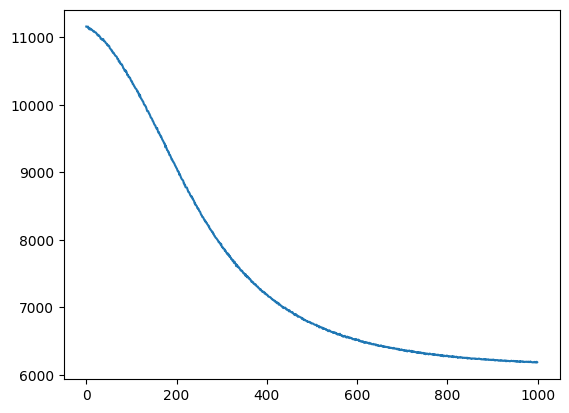

In [ ]:
plt.plot(results.losses)

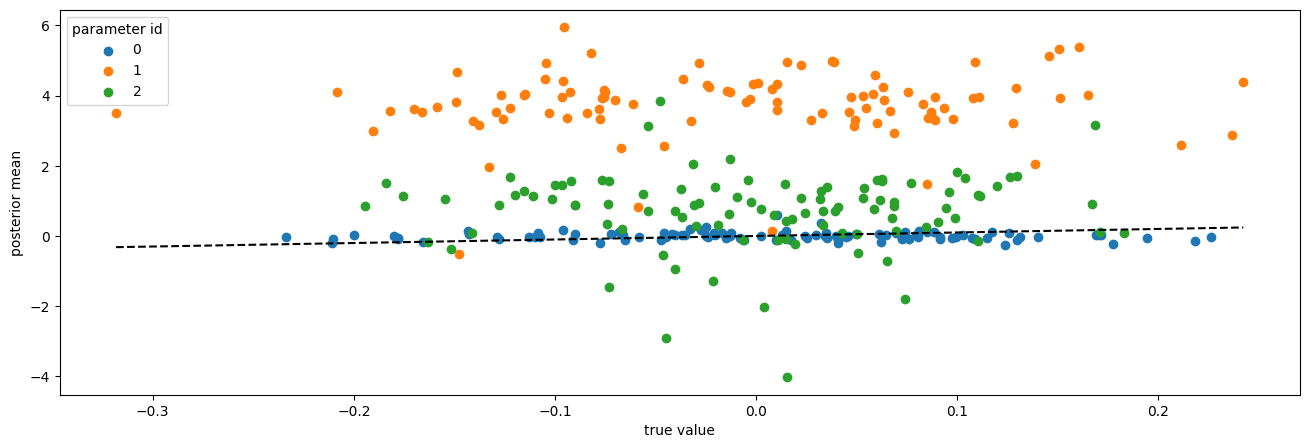

In [ ]:
plt.figure(figsize=(16, 5))
for i in range(3):
    plt.scatter(z[:, i], mcmc_samples["z"].mean(0)[:, i], label=i)

plt.plot((z.min(), z.max()), (z.min(), z.max()), "k--")
plt.ylabel("posterior mean")
plt.xlabel("true value")
plt.legend(title="parameter id")

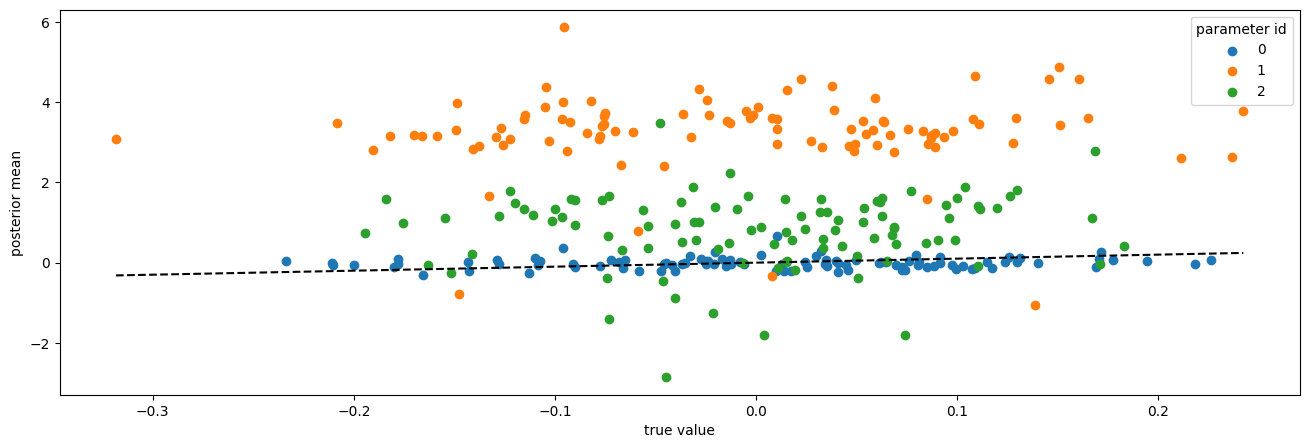

In [ ]:
plt.figure(figsize=(16, 5))
for i in range(3):
    plt.scatter(z[:, i], svi_samples["z"].mean(0)[:, i], label=i)

plt.plot((z.min(), z.max()), (z.min(), z.max()), "k--")
plt.ylabel("posterior mean")
plt.xlabel("true value")
plt.legend(title="parameter id")